### Libraries

In [ ]:
import cooler

from cooltools import insulation
import cooltools

import numpy as np
import pandas as pd

import bioframe

import seaborn as sns
import matplotlib.pyplot as plt

from itertools import combinations
import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import bbi

import matplotlib.colors as mcolors
def generate_colors(n):
    # Starting and ending colors
    start_color = "#465775"
    end_color = "#A63446"
    
    # Convert hex to RGB
    start_rgb = np.array(mcolors.hex2color(start_color))
    end_rgb = np.array(mcolors.hex2color(end_color))
    
    # Generate n evenly spaced colors
    colors = [mcolors.to_hex((1 - t) * start_rgb + t * end_rgb) for t in np.linspace(0, 1, n)]
    
    return colors

import data_handlers

### Hyperparameters

In [2]:
NPROC = 4
resolution = 10000
window = 50*resolution

sample_names = [0,12,30,60]
comparisons = [(0,1), (1,2), (2,3)]
comparisons_str = ['Control -> 12 min', '12 min -> 30 min', '30 min -> 60 min']

sample_names_str = ['Control', '12 min', '30 min', '60 min']

clr_ = [cooler.Cooler(f"/home/carlos/oldies/manuscripts/notebooks/matrices/t{sample}_q30.mcool::resolutions/{resolution}") for sample in sample_names]

### Boundary Calling using ISs

In [3]:
# insulation_table_ = [
#     insulation(clr, 
#     [window], 
#     verbose=False, 
#     nproc = NPROC) 
#     for clr in clr_
#     ]

# for i, ins_df in enumerate(insulation_table_):
#     ins_df.to_csv(f"insulation_{sample_names_str[i]}.tsv", sep="\t", index=False)

In [4]:
insulation_table_ = [pd.read_csv(f"insulation_{sample_names_str[i]}.tsv", sep="\t") for i in range(len(sample_names))]

### Boundary comparison

In [5]:
accepted_range = 1

results = []

for comp_idx, (i,j) in enumerate(comparisons):

    s1_name, s2_name = sample_names_str[i], sample_names_str[j]

    results.append({
        'Preserved': {
            'Increase': [],
            'Decrease': []
        },
        'Non-Preserved': {
            'Gain': [],
            'Lost': []
        }
    })

    ins_df1, ins_df2 = insulation_table_[i].copy(), insulation_table_[j].copy()

    is_boundary1_idx = ins_df1.loc[ins_df1[f'is_boundary_{window}'] == True].index.to_numpy().astype(int)
    is_boundary1_idx_expanded = []
    is_boundary1_idx_expanded_original = []
    for idx in is_boundary1_idx:
        is_boundary1_idx_expanded.extend(range(idx-accepted_range, idx+accepted_range+1))
        is_boundary1_idx_expanded_original.extend([idx] * (accepted_range*2+1))

    is_boundary2_idx = ins_df2.loc[ins_df2[f'is_boundary_{window}'] == True].index.to_numpy().astype(int)
    is_boundary2_idx_expanded = []
    is_boundary2_idx_expanded_original = []
    for idx in is_boundary2_idx:
        is_boundary2_idx_expanded.extend(range(idx-accepted_range, idx+accepted_range+1))
        is_boundary2_idx_expanded_original.extend([idx] * (accepted_range*2+1))

    preserved_raw = []

    non_preserved_raw_1 = []
    non_preserved_raw_2 = []

    for idx_2 in is_boundary2_idx:
        if idx_2 in is_boundary1_idx_expanded:
            idx_on_1 = is_boundary1_idx_expanded_original[is_boundary1_idx_expanded.index(idx_2)]
            preserved_raw.append((idx_on_1, idx_2))
        else:
            non_preserved_raw_2.append(idx_2)

    for idx_1 in is_boundary1_idx:
        if idx_1 not in is_boundary2_idx_expanded:
            non_preserved_raw_1.append(idx_1)

    results[comp_idx]['Non-Preserved']['Gain'] = non_preserved_raw_2
    results[comp_idx]['Non-Preserved']['Lost'] = non_preserved_raw_1

    for idx_1, idx_2 in preserved_raw:
        bs1, bs2 = ins_df1.iloc[idx_1][f'boundary_strength_{window}'], ins_df2.iloc[idx_2][f'boundary_strength_{window}']
        if bs2 > bs1:
            results[comp_idx]['Preserved']['Increase'].append((idx_1, idx_2))
        else:
            results[comp_idx]['Preserved']['Decrease'].append((idx_1, idx_2))

    # refine gain lost

    def get_bs_threshold(ins_df, window):
        which_are_boundaries = ins_df[f'is_boundary_{window}']
        bs_rows = ins_df[f'boundary_strength_{window}'][which_are_boundaries]
        return bs_rows.min()

    bs1_threshold = get_bs_threshold(ins_df1, window)
    bs2_threshold = get_bs_threshold(ins_df2, window)

    is_insulating_1 = ins_df1[f'boundary_strength_{window}'] > bs2_threshold
    is_insulating_2 = ins_df2[f'boundary_strength_{window}'] > bs1_threshold

    is_insulating_1_idx = ins_df1.loc[is_insulating_1].index.to_numpy().astype(int)
    is_insulating_2_idx = ins_df2.loc[is_insulating_2].index.to_numpy().astype(int)

    is_insulating_1_idx_expanded = []
    for idx in is_insulating_1_idx:
        is_insulating_1_idx_expanded.extend(range(idx-accepted_range, idx+accepted_range+1))
    
    is_insulating_2_idx_expanded = []
    for idx in is_insulating_2_idx:
        is_insulating_2_idx_expanded.extend(range(idx-accepted_range, idx+accepted_range+1))

    for idx_2 in results[comp_idx]['Non-Preserved']['Gain']:
        if idx_2 in is_insulating_2_idx_expanded:
            results[comp_idx]['Non-Preserved']['Gain'].remove(idx_2)
    
    for idx_1 in results[comp_idx]['Non-Preserved']['Lost']:
        if idx_1 in is_insulating_1_idx_expanded:
            results[comp_idx]['Non-Preserved']['Lost'].remove(idx_1)

In [ ]:
for comp_idx, _ in enumerate(comparisons):
    local_dict = results[comp_idx]
    for key, value in local_dict.items():
        for key2, value2 in value.items():
            print(f"{comparisons_str[comp_idx]}: {key} / {key2} ::: {len(value2)}")

In [7]:
# prepare dfs

comps_dfs_ = []

for comp_idx, _ in enumerate(comparisons):
    results_now = results[comp_idx]

    df_now = pd.DataFrame(
        {
            'sample1': [],
            'sample2': [],
            'type': [],
            'dir': [],
            'idx1': [],
            'idx2': [],
        }
    )

    preserved_increase = results_now['Preserved']['Increase']
    preserved_decrease = results_now['Preserved']['Decrease']
    non_preserved_gain = results_now['Non-Preserved']['Gain']
    non_preserved_lost = results_now['Non-Preserved']['Lost']

    for idx1, idx2 in preserved_increase:
        df_now = df_now.append({
            'sample1': sample_names_str[comparisons[comp_idx][0]],
            'sample2': sample_names_str[comparisons[comp_idx][1]],
            'type': 'Preserved',
            'dir': 'Increase',
            'idx1': idx1.astype(int),
            'idx2': idx2.astype(int)
        }, ignore_index=True)

    for idx1, idx2 in preserved_decrease:
        df_now = df_now.append({
            'sample1': sample_names_str[comparisons[comp_idx][0]],
            'sample2': sample_names_str[comparisons[comp_idx][1]],
            'type': 'Preserved',
            'dir': 'Decrease',
            'idx1': idx1.astype(int),
            'idx2': idx2.astype(int)
        }, ignore_index=True)

    for idx2 in non_preserved_gain:
        df_now = df_now.append({
            'sample1': sample_names_str[comparisons[comp_idx][0]],
            'sample2': sample_names_str[comparisons[comp_idx][1]],
            'type': 'Non-Preserved',
            'dir': 'Gain',
            'idx1': np.nan,
            'idx2': idx2.astype(int)
        }, ignore_index=True)
    
    for idx1 in non_preserved_lost:
        df_now = df_now.append({
            'sample1': sample_names_str[comparisons[comp_idx][0]],
            'sample2': sample_names_str[comparisons[comp_idx][1]],
            'type': 'Non-Preserved',
            'dir': 'Lost',
            'idx1': idx1.astype(int),
            'idx2': np.nan
        }, ignore_index=True)

    comps_dfs_.append(df_now)

In [8]:
for idx_df, df in enumerate(comps_dfs_):
    s1, s2 = comparisons[idx_df]
    ins_df1, ins_df2 = insulation_table_[s1].copy(), insulation_table_[s2].copy()
    idx1 = df.loc[pd.notnull(df.idx1)].idx1.astype(int).to_numpy()
    idx2 = df.loc[pd.notnull(df.idx2)].idx2.astype(int).to_numpy()

    df.loc[pd.notnull(df.idx1), 'bs1'] = ins_df1.iloc[idx1][f'boundary_strength_{window}'].to_numpy()
    df.loc[pd.notnull(df.idx2), 'bs2'] = ins_df2.iloc[idx2][f'boundary_strength_{window}'].to_numpy()

    df['comparison'] = comparisons_str[idx_df]

In [ ]:
comps_dfs_[0].loc[comps_dfs_[0].type == 'Preserved']

### BS Overall

In [10]:
# plot raincloud plots on exported insulation dfs for boundary strength changes (bs_raincloud.ipynb)

### Boundary Change Number

In [ ]:
merged_dfs = pd.concat(comps_dfs_).reset_index(drop=True)
merged_dfs.loc[merged_dfs.type == 'Preserved', "dir"] = "Preserved"

fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(5, 5), gridspec_kw={'hspace': .1})

# melt data comaprison ~ dir
merged_dfs['melt'] = 1
merged_dfs = merged_dfs.pivot_table(index='comparison', columns=['dir'], aggfunc='count', values='melt')

merged_dfs = merged_dfs.loc[comparisons_str]
merged_dfs = merged_dfs[['Preserved', 'Lost', 'Gain']]

merged_dfs.plot(kind='bar', stacked=True, color=["#465775", "#A63446", "#F5B841"], ax = ax1, legend=True, width=.4, align='center')

for tick_idx in range(3):
    x_pos = tick_idx
    y_pos = 0
    for state in ['Preserved', 'Gain', 'Lost']:
        count = merged_dfs.iloc[tick_idx][state]
        y_pos += count
        ax1.text(x_pos, y_pos - count/2, count, ha='center', va='center', rotation=0, fontsize=14, color='#FDFFFC')

# change legend title
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, ['Preserved', 'Lost', 'Gain'], title='Type', loc='upper right', fontsize=12)

ax1.set_ylabel('Number of boundaries', fontsize=15)
ax1.set_xlabel('Transitions', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='both', which='minor', labelsize=12)

# rotate x labels
ax1.set_xticklabels([comp_name.replace("->", "-\n") for comp_name in comparisons_str])
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, horizontalalignment='right')

fig.savefig('boundary_transitions.png', dpi=300, bbox_inches='tight')
fig.savefig('boundary_transitions.svg', bbox_inches='tight')

### Ridgeline

In [ ]:
from joypy import joyplot

merged_dfs = pd.concat(comps_dfs_).reset_index(drop=True)
merged_dfs = merged_dfs.loc[merged_dfs.type == 'Preserved']
merged_dfs['bs_change'] = merged_dfs.bs2 - merged_dfs.bs1

merged_dfs['comparison'] = pd.Categorical(merged_dfs['comparison'], categories=comparisons_str, ordered=True)

from matplotlib.colors import LinearSegmentedColormap
cmp = LinearSegmentedColormap.from_list("custom_cmp", ["#465775", "#A63446", "#F5B841"], N=3)

fig, ax_j = plt.subplots(figsize=(8, 5))

j = joyplot(merged_dfs, by="comparison", column="bs_change", figsize=(8, 5), fade=True, colormap=cmp, x_range=[-0.5, 0.5], ylim = 'max',
    grid="y", linewidth=1, legend=False, overlap=1, bins=50, title='$Δ$ Boundary Strength', ax = ax_j)


for ax in j[1][:3]:
    ax.set_xlabel('')
    ax.set_xlim(-0.5, 0.5)
    ax.set_xticks([-0.5, 0, 0.5])
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1.2)
    ax.set_ylabel('')
    ax.set_title('')
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)


j[1][3].set_title('$Δ$ Boundary Strength', fontsize=20)
j[1][3].tick_params(axis='both', which='major', labelsize=15)
j[1][3].tick_params(axis='both', which='minor', labelsize=15)
fig.savefig('boundary_strength_changes.png', dpi=300, bbox_inches='tight')
fig.savefig('boundary_strength_changes.svg', bbox_inches='tight')

### Make TADs

In [23]:
# prep expected for background in viz
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)
hg38_arms = hg38_arms.set_index("chrom").loc[clr_[0].chromnames].reset_index()
hg38_arms = bioframe.make_viewframe(hg38_arms)

expected_ = [cooltools.expected_cis(
        clr=clr,
        view_df=hg38_arms,
        smooth=False,
        aggregate_smoothed=False,
        nproc=NPROC,
        clr_weight_name='weight') for clr in clr_]

In [24]:
# get tads
def make_tads(insul_df, maxlen=1_500_000, minlen=100_000):

        tads = (
        insul_df.groupby("chrom")
        .apply(
            lambda x: pd.concat(
                [x[:-1].reset_index(drop=True), x[1:].reset_index(drop=True)],
                axis=1,
                ignore_index=True,
            )
        )
        .reset_index(drop=True)
        )
        tads.columns = [["chrom1", "start1", "end1", "chrom2", "start2", "end2"]]
        tads.columns = tads.columns.get_level_values(0)

        tads = tads[
            ((tads["start2"] - tads["start1"]) <= maxlen) & ((tads["start2"] - tads["start1"]) >= minlen)
        ].reset_index(drop=True)

        tads["start"] = (tads["start1"] + tads["end1"]) // 2
        tads["end"] = (tads["start2"] + tads["end2"]) // 2
        tads = tads[["chrom1", "start", "end"]]
        tads.columns = ['chrom', 'start', 'end']
        return tads

from coolpuppy import coolpup
from coolpuppy.lib.numutils import get_domain_score

def add_domain_score(snippet):
    snippet['domain_score'] = f"{get_domain_score(snippet['data'])}_{snippet['chrom1']}_{snippet['start1']}_{snippet['end1']}_{snippet['chrom2']}_{snippet['start2']}_{snippet['end2']}"
    return snippet

from more_itertools import collapse
def accumulate_values(dict1, dict2, key):
    assert key in dict2, f"{key} not in dict2"
    if key in dict1:
        dict1[key] = list(collapse([dict1[key], dict2[key]]))
    else:
        dict1[key] = [dict2[key]]
    return dict1

def extra_sum_func(dict1, dict2):
    return accumulate_values(dict1, dict2, 'domain_score')

In [25]:
merged_dfs = pd.concat(comps_dfs_).reset_index(drop=True)
merged_dfs = merged_dfs.loc[merged_dfs.type == 'Preserved']
merged_dfs = merged_dfs.loc[(merged_dfs.sample1 == 'Control') & (merged_dfs.sample2 == '12 min')]
boundary_idxs = merged_dfs.idx1.to_numpy().astype(int)
coords_table = insulation_table_[0].iloc[boundary_idxs][['chrom', 'start', 'end']].copy().reset_index(drop=True)

tads_df = make_tads(coords_table, maxlen=3e6)

In [ ]:
cc = coolpup.CoordCreator(tads_df, resolution=10000, features_format='bed', local=True, rescale_flank=1)
hg38_arms_filtered_idx = hg38_arms.loc[hg38_arms['name'].isin(bioframe.overlap(hg38_arms, tads_df, how='inner').name.unique())].index

hg38_arms_filtered = hg38_arms.loc[hg38_arms_filtered_idx].reset_index(drop=True)

pu = coolpup.PileUpper(clr_[0], cc, expected=expected_[0], view_df=hg38_arms_filtered, ignore_diags=0, rescale_size=99, rescale=True, nproc = NPROC)
pup = pu.pileupsWithControl(postprocess_func=add_domain_score,
                            extra_sum_funcs={
                                'domain_score': extra_sum_func}
                            )

In [27]:
n_q = 4
q_labels = [f'Q{i}' for i in range(1, n_q+1)]

scores = [float(val.split('_')[0]) for val in pup['domain_score'][0] if val.split('_')[0] != 'nan']
df = pd.DataFrame([val.split('_')[1:4] for val in pup['domain_score'][0] if val.split('_')[0] != 'nan'])
df.columns = ['chrom', 'start', 'end']
quartiles = pd.qcut(scores, q=n_q, labels=q_labels)
df['quartiles'] = quartiles
df['scores'] = scores

df.chrom = df.chrom.astype('category')
df.start = df.start.astype('int64')
df.end = df.end.astype('int64')

tad_domains_strengths = df
tad_domains_strengths.to_csv('tads_df.tsv', sep='\t', index=False)

In [ ]:
pup_per_quant = {}
for quant in q_labels:
    curr_df = tad_domains_strengths.loc[tad_domains_strengths['quartiles'] == quant]
    cc = coolpup.CoordCreator(curr_df, resolution=10000, features_format='bed', local=True, rescale_flank=1)
    pu = coolpup.PileUpper(clr_[1], cc, expected=expected_[1], view_df=hg38_arms, ignore_diags=0, rescale_size=99, rescale=True)
    pup_per_quant[quant] = pu.pileupsWithControl()

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
cmp = LinearSegmentedColormap.from_list("custom_cmp", ["#14213D", "white", "#C42021"], N=256)

fig, axs = plt.subplots(figsize=(52, 10), nrows=1, ncols=4, sharex=True, sharey=True)
for i, quant in enumerate(q_labels):
    pup_now = pup_per_quant[quant].copy()
    ax = axs.flatten()[i]

    data = pup_now['data'][0].copy()
    # mask lower triangle
    mask = np.tril(np.ones_like(data, dtype=bool))
    sns.heatmap(data, ax=ax, cmap = cmp, yticklabels=False, xticklabels=False, cbar=True, mask=mask, vmax = 2, vmin = 0, square=True, center=1)
    ax.set_title(quant, fontsize=32)

    # make the colorbar labels bigger
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=18)

    # legend title
    cbar.set_label('Observed / Expected', fontsize=28)

fig.savefig('tad_domains_strengths.png', dpi=300, bbox_inches='tight')
fig.savefig('tad_domains_strengths.svg', bbox_inches='tight')

In [ ]:
tad_domains_strengths['length'] = tad_domains_strengths.end - tad_domains_strengths.start
lengths_q = tad_domains_strengths.groupby('quartiles')
fig, ax = plt.subplots(figsize=(10, 5))

s = sns.boxplot(x='quartiles', y='length', data=tad_domains_strengths, ax=ax, palette=["#465775"])

s.set_ylabel('Length (Mbp)', fontsize=15)
s.set_title('TAD Lengths', fontsize=15)
s.set_xlabel('Quartile', fontsize=15)

s.tick_params(axis='both', which='major', labelsize=12)
s.tick_params(axis='both', which='minor', labelsize=12)

fig.savefig('tad_domains_lengths_q.png', dpi=300, bbox_inches='tight')
fig.savefig('tad_domains_lengths_q.svg', bbox_inches='tight')

In [ ]:
plot_data = {
    'sample': [],
    'q': [],
    'data' : []
}

from statannotations.Annotator import Annotator

for i, q in enumerate(q_labels):

    df_now = tad_domains_strengths.loc[tad_domains_strengths.quartiles == q].copy()
    ev_1 = bbi.stackup(data_handlers.BWS['e1_0'], df_now.chrom, df_now.start, df_now.end, 1).flatten().tolist()
    ev_2 = bbi.stackup(data_handlers.BWS['e1_12'], df_now.chrom, df_now.start, df_now.end, 1).flatten().tolist()

    plot_data['sample'].extend(['Control']*len(ev_1) + ['12 min']*len(ev_2))
    plot_data['q'].extend([q]*len(ev_1)*2)
    plot_data['data'].extend(ev_1 + ev_2)

plot_data = pd.DataFrame(plot_data)

fig, ax = plt.subplots(figsize=(10, 5))

pairs = [
    (('Q1', 'Control'), ('Q1', '12 min')), 
    (('Q2', 'Control'), ('Q2', '12 min')), 
    (('Q3', 'Control'), ('Q3', '12 min')), 
    (('Q4', 'Control'), ('Q4', '12 min'))
    ]

s = sns.boxplot(x='q', y='data', hue='sample', data=plot_data, ax=ax, palette=generate_colors(2))
# ax.get_legend().remove()

# change legend title
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Control', '12 min'], title='Sample', loc='upper right', fontsize=12)

# annotator = Annotator(ax, pairs, data=plot_data, x='q', y='data', hue='sample')
# annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
# annotator.apply_and_annotate()

s.set_title('Compartment EV', fontsize=15)
s.set_ylabel('Avg. EV per TAD', fontsize=15)
s.set_xlabel('Quartile', fontsize=15)

s.tick_params(axis='both', which='major', labelsize=12)
s.tick_params(axis='both', which='minor', labelsize=12)

fig.savefig('tad_domains_ev_q.png', dpi=300, bbox_inches='tight')
fig.savefig('tad_domains_ev_q.svg', bbox_inches='tight')

In [ ]:
plot_data = {
    'q': [],
    'data' : [],
}

for i, q in enumerate(q_labels):
    df_now = tad_domains_strengths.loc[tad_domains_strengths.quartiles == q].copy()
    data = bbi.stackup(data_handlers.BWS['dnase'], df_now.chrom, df_now.start, df_now.end, 1).flatten()
    data = data / data_handlers.MEANS_BW['dnase']
    data = data.tolist()
    plot_data['q'].extend([q]*len(data))
    plot_data['data'].extend(data)


plot_data = pd.DataFrame(plot_data)

fig, ax = plt.subplots(figsize=(10, 5))
#s = sns.violinplot(x='q', y='data', data=plot_data, ax=ax, palette=generate_colors(1), split=False)
s = sns.boxplot(x='q', y='data', data=plot_data, ax=ax, palette=generate_colors(1))

s.set_title('Pre-UV DNAse-Seq Levels', fontsize=15)
s.set_ylabel('Avg. Levels Per TAD', fontsize=15)
s.set_xlabel('Quartile', fontsize=15)

s.tick_params(axis='both', which='major', labelsize=12)
s.tick_params(axis='both', which='minor', labelsize=12)

fig.savefig('tad_domains_dnase_q.png', dpi=300, bbox_inches='tight')
fig.savefig('tad_domains_dnase_q.svg', bbox_inches='tight')

In [ ]:
plot_data = {
    'q': [],
    'data' : [],
}

for i, q in enumerate(q_labels):
    df_now = tad_domains_strengths.loc[tad_domains_strengths.quartiles == q].copy()
    data = bbi.stackup(data_handlers.BWS['faire'], df_now.chrom, df_now.start, df_now.end, 1).flatten().tolist()
    data = data / data_handlers.MEANS_BW['faire']
    data = data.tolist()
    plot_data['q'].extend([q]*len(data))
    plot_data['data'].extend(data)


plot_data = pd.DataFrame(plot_data)

fig, ax = plt.subplots(figsize=(10, 5))
#s = sns.violinplot(x='q', y='data', data=plot_data, ax=ax, palette=generate_colors(1), split=False)
s = sns.boxplot(x='q', y='data', data=plot_data, ax=ax, palette=generate_colors(1))

s.set_title('Pre-UV  Faire-Seq Levels', fontsize=15)
s.set_ylabel('Avg. Levels Per TAD', fontsize=15)
s.set_xlabel('Quartile', fontsize=15)

s.tick_params(axis='both', which='major', labelsize=12)
s.tick_params(axis='both', which='minor', labelsize=12)

fig.savefig('tad_domains_faire_q.png', dpi=300, bbox_inches='tight')
fig.savefig('tad_domains_faire_q.svg', bbox_inches='tight')

In [41]:
start_data, main_data, end_data = data_handlers._bw_data(tad_domains_strengths, 100_000, 25, 25, 50)

In [42]:
plot_data = {
    'q': [],
    'data' : [],
    'n': []
    }

data_names = ['dnase']

for i, q in enumerate(q_labels):
    idx = tad_domains_strengths.loc[tad_domains_strengths.quartiles == q].index
    for dn in data_names:
        start_data_now = start_data[dn][idx]
        main_data_now = main_data[dn][idx]
        end_data_now = end_data[dn][idx]
        start_data_now = np.nanmean(start_data_now, axis=0)
        main_data_now = np.nanmean(main_data_now, axis=0)
        end_data_now = np.nanmean(end_data_now, axis=0)

        stack = np.hstack([start_data_now, main_data_now, end_data_now])

        # import gaussian_filter1d
        from scipy.ndimage import gaussian_filter1d

        stack = gaussian_filter1d(stack, 1)

        plot_data['q'].extend([q]*len(stack))
        plot_data['data'].extend(stack)
        plot_data['n'].extend(np.arange(len(stack)))

plot_data = pd.DataFrame(plot_data)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
s = sns.lineplot(x='n', y='data', hue='q', data=plot_data, ax=ax, palette=generate_colors(4))

s.set_ylabel('DNAse-Seq Levels', fontsize=16)
s.set_xlabel('Quartile', fontsize=16)

s.tick_params(axis='both', which='major', labelsize=12)
s.tick_params(axis='both', which='minor', labelsize=12)

fig.savefig('tad_domains_dnase_q.png', dpi=300, bbox_inches='tight')
fig.savefig('tad_domains_dnase_q.svg', bbox_inches='tight')

#### obs/exp changes on TAD isolation

In [ ]:
pup_per_quant = {}
for quant in q_labels:
    curr_df = tad_domains_strengths.loc[tad_domains_strengths['quartiles'] == quant]
    cc = coolpup.CoordCreator(curr_df, resolution=10000, features_format='bed', local=True, rescale_flank=1)
    pu = coolpup.PileUpper(clr_[0], cc, expected=expected_[0], view_df=hg38_arms, ignore_diags=0, rescale_size=99, rescale=True, nproc = NPROC)
    pup_1 = pu.pileupsWithControl()

    curr_df = tad_domains_strengths.loc[tad_domains_strengths['quartiles'] == quant]
    cc = coolpup.CoordCreator(curr_df, resolution=10000, features_format='bed', local=True, rescale_flank=1)
    pu = coolpup.PileUpper(clr_[1], cc, expected=expected_[1], view_df=hg38_arms, ignore_diags=0, rescale_size=99, rescale=True, nproc = NPROC)
    pup_2 = pu.pileupsWithControl()

    from coolpuppy.lib.puputils import divide_pups
    
    divide_pup = divide_pups(pup_2, pup_1)

    pup_per_quant[quant] = divide_pup

# for i, quant in enumerate(q_labels):
#     ax = axs[1, i]
#     sns.lineplot(x='n', y='data', hue='type', data=plot_df.loc[plot_df.q == quant], ax=ax, palette=generate_colors(1))
#     ax.set_title(quant, fontsize=32)

In [ ]:
fig, axs = plt.subplots(figsize=(52, 10), nrows=1, ncols=4, sharex=True, sharey=True)

mats = []
for i, quant in enumerate(q_labels):
    pup_now = pup_per_quant[quant].copy()
    data = pup_now['data'][0].copy().flatten()
    mats.append(data)

vmin, vmax = np.nanmin(np.stack(mats)), np.nanmax(np.stack(mats))

for i, quant in enumerate(q_labels):
    pup_now = pup_per_quant[quant].copy()
    data = pup_now['data'][0].copy()
    ax=axs[i]
    # # mask lower triangle
    mask = np.tril(np.ones_like(data, dtype=bool))
    mask[np.diag_indices_from(mask)] = False
    
    sns.heatmap(data, ax=ax, cmap = cmp, yticklabels=False, xticklabels=False, cbar=True, mask=mask, square=True, center = 1
                , vmin=vmin, vmax=vmax,
                #vmin=0.75, vmax=1.2, 
                )
    ax.set_title(quant, fontsize=32)

    # make the colorbar labels bigger
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=18)

    # legend title log2 12 min OE / Control OE, where "OE" and "2" are subscript
    title=r'$\log_{2} \, \frac{\mathrm{12 \, min}_{\mathrm{OE}}}{\mathrm{Control}_{\mathrm{OE}}}$'
    cbar.set_label(title, fontsize=28)

    # make the colorbar labels bigger
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=18)

fig.savefig('tad_domains_strengths_oe_fc.png', dpi=300, bbox_inches='tight')
fig.savefig('tad_domains_strengths_oe_fc.svg', bbox_inches='tight')


### Normalized Repair Levels

In [59]:
start_data, main_data, end_data = data_handlers._bw_data(tad_domains_strengths, 100_000, 25, 25, 50)
#_, corr_main_data, _ = _bw_data(tad_domains_strengths, 10_000, 1, 1, 1)

In [ ]:
data_names = ["xr-cpd-over-sim", "xr-64-over-sim",]
fig, axs = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(20, 20),
    sharey="row",
    # make plots closer
    gridspec_kw=dict(wspace=0.03)
)

from scipy.ndimage import gaussian_filter1d


tad_domains_strengths['length'] = tad_domains_strengths['end'] - tad_domains_strengths['start']
tad_domains_strengths['length'] /= 1e6

for col_idx, rep in enumerate(data_names):

    means_ = []
    for q in q_labels:
        # tad domain strengths at 12min, index 1
        idx_ = tad_domains_strengths.loc[tad_domains_strengths['quartiles'] == q].index
        main = np.nanmean(main_data[rep][idx_], axis=0)
        start = np.nanmean(start_data[rep][idx_], axis=0)
        end = np.nanmean(end_data[rep][idx_], axis=0)
        data = np.hstack([start, main, end])

        # local_df = tad_domains_strengths.loc[tad_domains_strengths['quartiles'] == q].copy()
        # start_df = local_df.copy()
        # start_df['end'] = start_df['start']
        # start_df['start'] = start_df['start'] - 50_000

        # end_df = local_df.copy()
        # end_df['start'] = end_df['end']
        # end_df['end'] = end_df['end'] + 50_000

        # main = region_per_df_wrapper(local_df, bws_per_key[rep], 100, interval_size=1000, flank=0)
        # start = region_per_df_wrapper(start_df, bws_per_key[rep], 25, interval_size=1000, flank=0)
        # end = region_per_df_wrapper(end_df, bws_per_key[rep], 25, interval_size=1000, flank=0)
        
        # main = np.nanmean(main, axis=0)
        # start = np.nanmean(start, axis=0)
        # end = np.nanmean(end, axis=0)

        data = np.hstack([start, main, end])
        
        means_.append(gaussian_filter1d(data, sigma=1))
        #means_.append(data)
        
    ax = axs[0, col_idx]
    q_Df = {
        'data': np.hstack(means_),
        'q_data': np.hstack([[q] * len(arr) for q,arr  in zip(q_labels, means_)]),
        'n': np.hstack([np.arange(len(arr)) for arr in means_])
    }
    q_Df = pd.DataFrame(q_Df)
    q_Df['q_data'] = q_Df['q_data'].astype('category')
    # reorder categories
    q_Df['q_data'] = q_Df['q_data'].cat.reorder_categories(q_labels[::-1])
    s = sns.lineplot(
        data = q_Df,
        x = "n",
        y = "data",
        hue = "q_data", ax = ax,
        #palette = list(cpal.as_hex())[::-1],
        palette = ["#465775", "#A63446", "#F5B841", "#9DBBAE"],)
    
    ax.axvline(25, linestyle='--', color='black', alpha=.5)
    ax.axvline(75, linestyle='--', color='black', alpha=.5)
    ax.axhline(1, linestyle='--', color='black', alpha=.5)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xticks([25, 50, 75])
    ax.set_xticklabels(["5' Boundary", 'Intra-TAD', "3' Boundary"], fontsize=18)
    ax.set_xlabel('')
    
    sim_ss = '${sim}$'
    title = f'CPD / CPD {sim_ss}' if "cpd" in rep else f'6-4PP / 6-4PP {sim_ss}'
    # remove yaxis label
    ax.set_ylabel('Normalized Repair Levels', fontsize=18)

    # set title of plot
    ax.set_title(title, fontsize=18)
    
    
    # corr

    ax = axs[1, col_idx]

    repair_data = data_handlers.region_per_df_wrapper(tad_domains_strengths, data_handlers.bws_per_key[rep], 1, interval_size=1000, flank=0).flatten()
    dnase_data = data_handlers.region_per_df_wrapper(tad_domains_strengths, data_handlers.bws_per_key['dnase'], 1, interval_size=1000, flank=0).flatten()
    
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    dnase_data = scaler.fit_transform(dnase_data.reshape(-1, 1)).flatten()

    df = pd.DataFrame({
        'rep': repair_data,
        'length': tad_domains_strengths['length'],
        'dnase': dnase_data
        })

    windows = [(0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1)]
    def assign_window(val, w):
        for idx, (start, end) in enumerate(w):
            if start <= val <= end:
                return idx
        return -1
    
    #df['dnase_w'] = pd.qcut(df['dnase'], q=6, labels=q_labels)
    df['dnase_w'] = df['dnase'].apply(lambda x: assign_window(x, windows))

    # df = pd.DataFrame({
    #     'rep': region_per_df_wrapper(tad_domains_strengths, bws_per_key[rep], 1, interval_size=1000, flank=0).flatten(),
    #     'length': tad_domains_strengths['length'],
    #     })

    # s = sns.regplot(
    #     data=df,
    #     x='length', y='rep',
    #     # change marker size to 1
    #     scatter_kws = {"color": "#465775", "alpha": 1, "s": 5},
    #     line_kws = {"color": "#C1121F", "lw": 2}, fit_reg=True, order=1,
    #     ax=ax)
    
    colors = generate_colors(len(windows))

    sns.regplot(
        data=df,
        x='length', y='rep',
        scatter_kws = {"color": color, "alpha": 0.0, "s": 5},
        line_kws = {"color": 'black', "lw": 2, "linestyle": '--'}, fit_reg=True, order=1,
        ax=ax)
    import scipy
    stats_ = scipy.stats.pearsonr(x=df.length, y=df.rep)
    r, p = stats_[0], stats_[1]
    ax.text(0.2, 0.60, f"r = {r:.3f}", transform=ax.transAxes, fontsize=18)
    ax.text(0.10, 0.70, f"p = {p}", transform=ax.transAxes, fontsize=18)
    for i, color in enumerate(colors):
        data_now = df.loc[df.dnase_w == i]
        sns.regplot(
            data=data_now,
            x='length', y='rep',
            scatter_kws = {"color": color, "alpha": .7, "s": 5},
            line_kws = {"color": color, "lw": 2}, fit_reg=True, order=1,
            ax=ax)
    
        
        ax.ticklabel_format(style='plain', axis='both')

        stats_ = scipy.stats.pearsonr(x=data_now.length, y=data_now.rep)
        r, p = stats_[0], stats_[1]
        ax.text(0.80, 0.90 + i * 0.05, f"r = {r:.3f}", transform=ax.transAxes, fontsize=18)
        ax.text(0.30, 0.80 + i * 0.05, f"p = {p}", transform=ax.transAxes, fontsize=18)
        # ax.text(0.80, 0.90, f"r = {r:.3f}", transform=ax.transAxes, fontsize=18)
        # ax.text(0.30, 0.80, f"p = {p}", transform=ax.transAxes, fontsize=18)
    
    #ax.axhline(1, color='black', linestyle='--', lw=2)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlabel('TAD Length (Mb)', fontsize=18)
    ax.set_ylabel('Normalized Repair Levels', fontsize=18) if col_idx == 0 else ax.set_ylabel('')
    # create a string as "sim" as subscript notation for matplotlib
    sim_ss = '${sim}$'
    #title = f'Normalized Repair Levels\nCPD / CPD {sim_ss}' if "cpd" in rep else f'Normalized Repair Levels\n6-4PP / 6-4PP {sim_ss}'
    # remove yaxis label

    # limit y axis
    #ax.set_ylim(0.5, 1.75)

fig.savefig(f'tad_domains_quant.png', dpi=300, bbox_inches='tight')
fig.savefig(f'tad_domains_quant.svg', bbox_inches='tight')

In [ ]:
tad_domains_strengths['cpd_rep'] = data_handlers.region_per_df_wrapper(tad_domains_strengths, data_handlers.bws_per_key['xr-cpd-over-sim'], 1, interval_size=1000, flank=0).flatten()
tad_domains_strengths['64_rep'] = data_handlers.region_per_df_wrapper(tad_domains_strengths, data_handlers.bws_per_key['xr-64-over-sim'], 1, interval_size=1000, flank=0).flatten()
tad_domains_strengths['ev'] = bbi.stackup(data_handlers.BWS['e1_0'], tad_domains_strengths.chrom, tad_domains_strengths.start, tad_domains_strengths.end, 1).flatten()
ev_windows = [(-1, -0.5), (-0.5, 0), (0, 0.5), (0.5, 1)]
tad_domains_strengths['ev_w'] = tad_domains_strengths['ev'].apply(lambda x: assign_window(x, ev_windows))

fig, axs = plt.subplots(1,2, figsize=(20, 10), sharex=True, sharey=True, gridspec_kw=dict(wspace=0.03))
colors = generate_colors(len(ev_windows))
data_name_mapping = {
    'cpd_rep': 'CPD',
    '64_rep': '6-4PP'
}
for j, data_name in enumerate(['cpd_rep', '64_rep']):
    ax = axs[j]
    for i, color in enumerate(colors):
        data_now = tad_domains_strengths.loc[tad_domains_strengths.ev_w == i].copy()
        sns.regplot(
            data=data_now,
            x='length', y=data_name,
            scatter_kws = {"color": color, "alpha": .7, "s": 5},
            line_kws = {"color": color, "lw": 2}, fit_reg=True, order=1,
            ax=ax)
    ax.set_title(data_name_mapping[data_name], fontsize=15)
    ax.set_xlabel('TAD Length (Mb)', fontsize=15)
    ax.set_ylabel('Normalized Repair Levels', fontsize=15) if j == 0 else ax.set_ylabel('')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)

fig.savefig('tad_domains_ev.png', dpi=300, bbox_inches='tight')
fig.savefig('tad_domains_ev.svg', bbox_inches='tight')

### Pileups ~ Repair

In [219]:
merged_dfs = pd.concat(comps_dfs_).reset_index(drop=True)
bins_df = insulation_table_[0].iloc[:, :3].copy()

# groups = [
#     ['Increase','Gain'],
#     ['Decrease', 'Lost']
# ]

groups = [
    ['Increase'],
    ['Decrease']
]

merged_dfs.loc[merged_dfs.dir.isin(groups[0]), 'viz_group'] = "Insulation_Plus"
merged_dfs.loc[merged_dfs.dir.isin(groups[1]), 'viz_group'] = "Insulation_Minus"

merged_dfs = merged_dfs.loc[merged_dfs.comparison == 'Control -> 12 min']

for i, row in merged_dfs.iterrows():

    idx1, idx2 = row.idx1, row.idx2

    if pd.notnull(idx1):
        chrom, start, end = bins_df.iloc[int(idx1)].to_numpy()
    else:
        chrom, start, end = bins_df.iloc[int(idx2)].to_numpy()
    
    merged_dfs.loc[i, 'chrom'] = chrom
    merged_dfs.loc[i, 'start'] = int(start)
    merged_dfs.loc[i, 'end'] = int(end)

# put chrom, start, end in the first 3 columns
cols = merged_dfs.columns.to_list()
cols = cols[-3:] + cols[:-3]
merged_dfs = merged_dfs[cols]
merged_dfs['start'] = merged_dfs['start'].astype(int)
merged_dfs['end'] = merged_dfs['end'].astype(int)
merged_dfs = bioframe.sort_bedframe(merged_dfs)
merged_dfs.dropna(subset=['viz_group'], inplace=True)

In [220]:
merged_dfs.to_csv('insulation_changes.tsv', sep='\t', index=False)

#### Prepare bigwig data

In [221]:
def prep_stackups(regions, nbins, flank, mean_norm=True):

    if mean_norm:
        stackups = {k: bbi.stackup(v,
                            regions.chrom,
                            regions.start-flank,
                            regions.end+flank,
                            bins=nbins) / data_handlers.MEANS_BW[k] for k, v in data_handlers.BWS.items()}
    else:
        stackups = {k: bbi.stackup(v,
                            regions.chrom,
                            regions.start-flank,
                            regions.end+flank,
                            bins=nbins) for k, v in data_handlers.BWS.items()}
    return stackups

In [222]:
flank = 500_000
nbins = (flank * 2 + 10_000) // 1000 # 1000 bp is bw files' resolution
#nbins /= 10 # smooth by 10
nbins = int(nbins)
bins = clr_[0].bins()[:]

In [223]:
stackups_ins_plus = prep_stackups(merged_dfs.loc[merged_dfs.viz_group == "Insulation_Plus"], nbins, flank, mean_norm=True)
stackups_ins_minus = prep_stackups(merged_dfs.loc[merged_dfs.viz_group == "Insulation_Minus"], nbins, flank, mean_norm=True)

stackups_ins_plus_no_mean = prep_stackups(merged_dfs.loc[merged_dfs.viz_group == "Insulation_Plus"], nbins, flank, mean_norm=False)
stackups_ins_minus_no_mean = prep_stackups(merged_dfs.loc[merged_dfs.viz_group == "Insulation_Minus"], nbins, flank, mean_norm=False)

In [224]:
def mask_row_nans(arr, percentile=10):
    arr = np.nan_to_num(arr, nan=np.nan, posinf=np.nan, neginf=np.nan)
    nan_sums_perc = np.sum(np.isnan(arr), axis=1) / arr.shape[1] * 100
    mask_idx = nan_sums_perc > percentile
    return arr[~mask_idx]

In [225]:
stackups_ins_plus['64_dnase'] = mask_row_nans(np.log2(stackups_ins_plus_no_mean['xr-64-over-sim'] + 1) - np.log2(stackups_ins_plus_no_mean['dnase'] + 1))
stackups_ins_minus['64_dnase'] = mask_row_nans(np.log2(stackups_ins_minus_no_mean['xr-64-over-sim'] + 1) - np.log2(stackups_ins_minus_no_mean['dnase'] + 1))

stackups_ins_plus['cpd_dnase'] = mask_row_nans(np.log2(stackups_ins_plus_no_mean['xr-cpd-over-sim'] + 1) - np.log2(stackups_ins_plus_no_mean['dnase'] + 1))
stackups_ins_minus['cpd_dnase'] = mask_row_nans(np.log2(stackups_ins_minus_no_mean['xr-cpd-over-sim'] + 1) - np.log2(stackups_ins_minus_no_mean['dnase'] + 1))

In [226]:
from scipy.ndimage import gaussian_filter1d
def make_bw_df(bw_dict, sigma):
    bw_data = {
    'n': [],
    'val': [],
    'name': []
    }
    for i, k in enumerate(bw_dict.keys()):
        val = np.nanmean(bw_dict[k], axis=0)
        val = gaussian_filter1d(val, sigma = sigma) if sigma is not None else val
        bw_data['n'].extend(np.arange(len(val)).tolist())
        bw_data['val'].extend(val)
        bw_data['name'].extend([k] * len(val))

    bw_df = pd.DataFrame(bw_data)
    return bw_df

stackups_ins_plus_df = make_bw_df(stackups_ins_plus, 1)
stackups_ins_minus_df = make_bw_df(stackups_ins_minus, 1)

#### Prepare IS for plotting

In [227]:
def local_range(curr_df, start, end):
    return 2 ** curr_df.iloc[start:end][f"log2_insulation_score_{window}"].values

def get_insulation_data(ins_df, coord_df, n_flank = 50):
    arr_ = [[], []]
    for _, row in coord_df.iterrows():
        idx1, idx2 = row.idx1, row.idx2
        if pd.notnull(idx1) & pd.notnull(idx2):
            arr_[0].append(local_range(
                ins_df[0].copy(), 
                int(idx1) - n_flank, 
                int(idx1) + n_flank + 1))

            arr_[1].append(local_range(
                ins_df[1].copy(), 
                int(idx2) - n_flank, 
                int(idx2) + n_flank + 1))
        
        elif pd.notnull(idx1) & ~pd.notnull(idx2):
            arr_[0].append(local_range(
                ins_df[0].copy(), 
                int(idx1) - n_flank, 
                int(idx1) + n_flank + 1))

            arr_[1].append(local_range(
                ins_df[1].copy(), 
                int(idx1) - n_flank, 
                int(idx1) + n_flank + 1))
        
        elif ~pd.notnull(idx1) & pd.notnull(idx2):
            arr_[0].append(local_range(
                ins_df[0].copy(), 
                int(idx2) - n_flank, 
                int(idx2) + n_flank + 1))

            arr_[1].append(local_range(
                ins_df[1].copy(), 
                int(idx2) - n_flank, 
                int(idx2) + n_flank + 1))
        
    return arr_
            

ins_plus_raw = get_insulation_data(insulation_table_, merged_dfs.loc[merged_dfs.viz_group == "Insulation_Plus"])
ins_minus_raw = get_insulation_data(insulation_table_, merged_dfs.loc[merged_dfs.viz_group == "Insulation_Minus"])

# convert n.m arrays to pd df

def convert_to_df(arr_list, group_name):
    return pd.DataFrame(
        {
            'data': np.log2(np.array(arr_list).flatten()),
            'n': np.array([np.arange(len(arr)) for arr in arr_list]).flatten(),
            'group': group_name
        }
    )

ins_scores_plus = pd.concat([convert_to_df(ins_plus_raw[0], 'Control'), convert_to_df(ins_plus_raw[1], '12 min')]).reset_index(drop=True)
ins_scores_minus = pd.concat([convert_to_df(ins_minus_raw[0], 'Control'), convert_to_df(ins_minus_raw[1], '12 min')]).reset_index(drop=True)

#### Prepare obs/exp data

In [228]:
ins_plus_df = bioframe.sort_bedframe(merged_dfs.loc[merged_dfs.viz_group == "Insulation_Plus"].reset_index(drop=True).iloc[:, :3].copy())
ins_minus_df = bioframe.sort_bedframe(merged_dfs.loc[merged_dfs.viz_group == "Insulation_Minus"].reset_index(drop=True).iloc[:, :3].copy())

from coolpuppy.lib.puputils import divide_pups

ins_plus_pups = [coolpup.pileup(
    clr, 
    ins_plus_df, 
    features_format='bed', 
    view_df=hg38_arms, 
    local=True, 
    expected_df=expected, 
    flank=flank, 
    min_diag=0,
    nproc=NPROC) for clr, expected in zip(clr_[:2], expected_)]
pup_divide_plus_ = divide_pups(ins_plus_pups[1], ins_plus_pups[0])

ins_minus_pups = [coolpup.pileup(
    clr, 
    ins_minus_df, 
    features_format='bed', 
    view_df=hg38_arms, 
    local=True, 
    expected_df=expected, 
    flank=flank, 
    min_diag=0,
    nproc=NPROC) for clr, expected in zip(clr_[:2], expected_)]
pup_divide_minus_ = divide_pups(ins_minus_pups[1], ins_minus_pups[0])

INFO:coolpuppy:('chr4_p', 'chr4_p'): 41
INFO:coolpuppy:('chr1_p', 'chr1_p'): 106
INFO:coolpuppy:('chr2_q', 'chr2_q'): 105
INFO:coolpuppy:('chr4_q', 'chr4_q'): 94
INFO:coolpuppy:('chr5_q', 'chr5_q'): 120
INFO:coolpuppy:('chr3_p', 'chr3_p'): 67
INFO:coolpuppy:('chr1_q', 'chr1_q'): 108
INFO:coolpuppy:('chr5_p', 'chr5_p'): 33
INFO:coolpuppy:('chr6_p', 'chr6_p'): 62
INFO:coolpuppy:('chr7_p', 'chr7_p'): 53
INFO:coolpuppy:('chr2_p', 'chr2_p'): 83
INFO:coolpuppy:('chr3_q', 'chr3_q'): 86
INFO:coolpuppy:('chr6_q', 'chr6_q'): 85
INFO:coolpuppy:('chr10_p', 'chr10_p'): 28
INFO:coolpuppy:('chr7_q', 'chr7_q'): 82
INFO:coolpuppy:('chr8_q', 'chr8_q'): 83
INFO:coolpuppy:('chr11_q', 'chr11_q'): 74
INFO:coolpuppy:('chr8_p', 'chr8_p'): 39
INFO:coolpuppy:('chr10_q', 'chr10_q'): 73
INFO:coolpuppy:('chr9_p', 'chr9_p'): 28
INFO:coolpuppy:('chr12_p', 'chr12_p'): 34
INFO:coolpuppy:('chr11_p', 'chr11_p'): 46
INFO:coolpuppy:('chr9_q', 'chr9_q'): 78
INFO:coolpuppy:('chr13_q', 'chr13_q'): 71
INFO:coolpuppy:('chr12_q

#### Plot

In [229]:
def plot_bw(bw_df, palette, ax=None, ylabel=None, armlabel=250, xlabel=False):
    l = sns.lineplot(data=bw_df, x='n', y='val', hue='name', ax=ax, legend=False, palette=palette)
    end = bw_df['n'].max()
    l.set_xticks([0, end//2, end])
    if xlabel:
        l.set_xticklabels([f"-{armlabel}kb", 0, f"+{armlabel}kb"])
        l.set_xlabel('Distance from Boundary', fontsize=16)
    else:
        # remove xticks, xlabel
        l.set_xticklabels([])
        l.set_xlabel('')
    l.set_ylabel(ylabel, fontsize=14)
    yticks = [f"{i:.2f}" for i in l.get_yticks()]
    l.set_yticklabels(yticks)
    #increase tick size
    l.tick_params(axis='both', which='major', labelsize=12)

/tmp/ipykernel_26140/1120205339.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_yticklabels(yticks)
/tmp/ipykernel_26140/1120205339.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_yticklabels(yticks)
/tmp/ipykernel_26140/1120205339.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_yticklabels(yticks)
/tmp/ipykernel_26140/1120205339.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_yticklabels(yticks)
/tmp/ipykernel_26140/1120205339.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_yticklabels(yticks)
/tmp/ipykernel_26140/1120205339.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_yticklabels(yticks)
/tmp/ipykernel_26140/1120205339.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_yticklabels(yticks)
/tmp/i

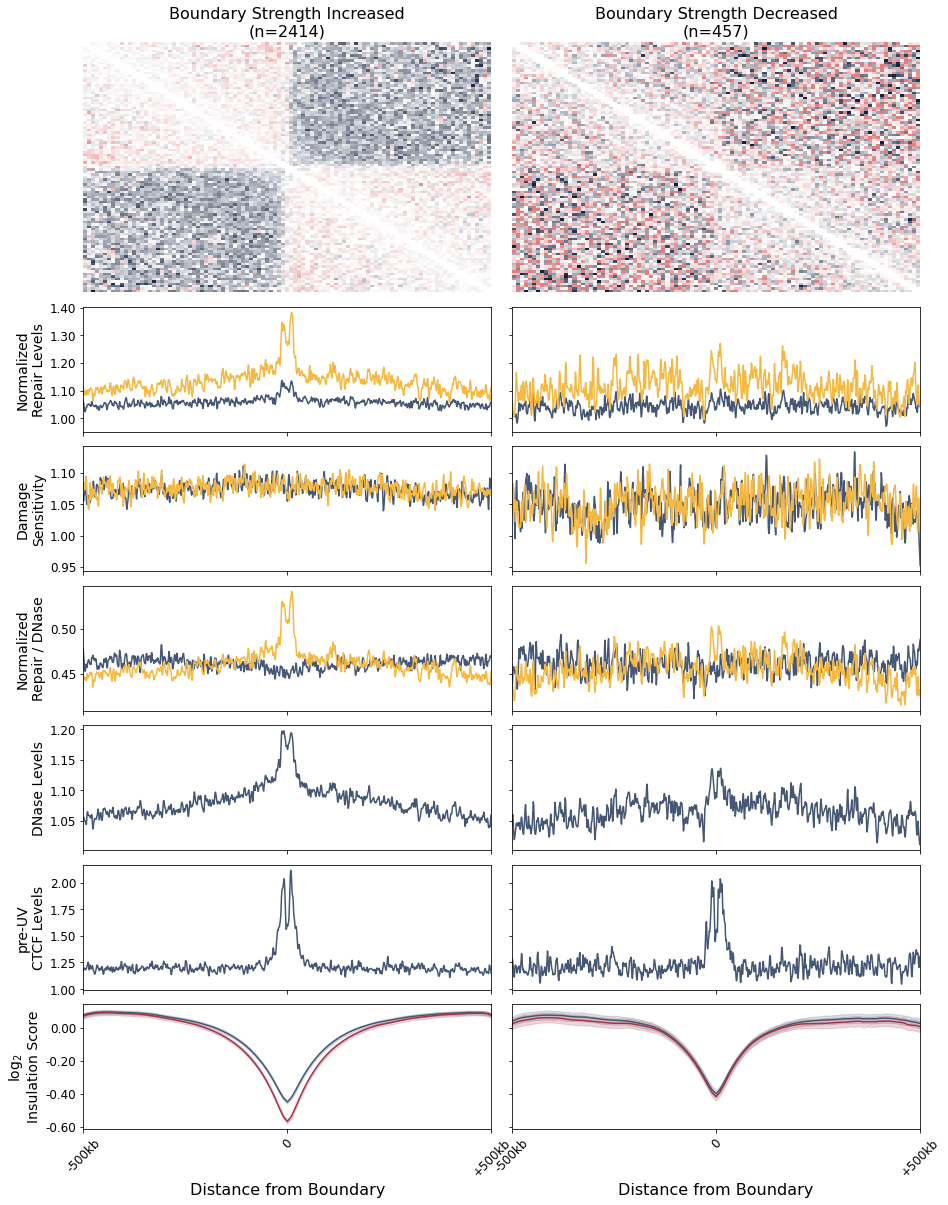

In [240]:
from matplotlib.colors import LinearSegmentedColormap
cmp = LinearSegmentedColormap.from_list("custom_cmp", ["#14213D", "white", "#C42021"], N=256)

height_ratios = np.array([1, .5, .5, .5, .5, .5, .5])
width_ratios = np.array([1, 1])
fig, ax = plt.subplots(
    nrows=7,  
    ncols=2, 
    sharex='row', 
    sharey='row', 
    figsize=(15, 20), 
    gridspec_kw={'height_ratios':height_ratios,
                 'width_ratios':width_ratios,
                 'hspace':0.10,
                 'wspace':0.05}
                 
                 )

from coolpuppy import plotpup
from matplotlib.colors import LogNorm

vmin, vmax = plotpup.get_min_max(
            pup_divide_plus_.data[0], 
            )

norm = LogNorm(vmin=vmin, vmax=vmax)

mtx1, mtx2 = pup_divide_plus_.data[0], pup_divide_minus_.data[0]
mtx1, mtx2 = np.log2(mtx1), np.log2(mtx2)
vmin, vmax = np.nanmin(mtx1), np.nanmax(mtx1)

hm = sns.heatmap(
    mtx1,
    ax=ax[0,0], 
    cmap=cmp, 
    center = 0, vmin=vmin, vmax=vmax,
    cbar=False, 
    xticklabels=False, 
    yticklabels=False,
    )
#hm.set_title(f'Boundary Strength Increased\nor Boundary Gain post-UV\n(n={len(merged_dfs.loc[merged_dfs.viz_group == "Insulation_Plus"])})', fontsize=16)
hm.set_title(f'Boundary Strength Increased\n(n={len(merged_dfs.loc[merged_dfs.viz_group == "Insulation_Plus"])})', fontsize=16)

hm = sns.heatmap(
    mtx2,
    ax=ax[0,1], 
    cmap=cmp, 
    center = 0, vmin=vmin, vmax=vmax,
    cbar=False, 
    xticklabels=False, 
    yticklabels=False,
    )
#hm.set_title(f'Boundary Strength Decreased\nor Boundary Lost post-UV\n(n={len(merged_dfs.loc[merged_dfs.viz_group == "Insulation_Minus"])})', fontsize=16)
hm.set_title(f'Boundary Strength Decreased\n(n={len(merged_dfs.loc[merged_dfs.viz_group == "Insulation_Minus"])})', fontsize=16)

stackups_ins_plus_df_repair = stackups_ins_plus_df.loc[stackups_ins_plus_df.name.isin(['xr-cpd-over-sim', 'xr-64-over-sim'])]
stackups_ins_minus_df_repair = stackups_ins_minus_df.loc[stackups_ins_minus_df.name.isin(['xr-cpd-over-sim', 'xr-64-over-sim'])]

plot_bw(stackups_ins_plus_df_repair, ax=ax[1,0], ylabel='Normalized\nRepair Levels', palette=['#465775', '#F5B841'], armlabel=flank//1000)
plot_bw(stackups_ins_minus_df_repair, ax=ax[1,1], ylabel='', palette=['#465775', '#F5B841'], armlabel=flank//1000)
ax[1,0].margins(x=0)
ax[1,1].margins(x=0)
ax[1,0].tick_params(axis='both', which='major', labelsize=12)
ax[1,1].tick_params(axis='both', which='major', labelsize=12)
ax[1,0].tick_params(axis='both', which='minor', labelsize=12)
ax[1,1].tick_params(axis='both', which='minor', labelsize=12)

stackups_ins_plus_df_damage = stackups_ins_plus_df.loc[stackups_ins_plus_df.name.isin(['ds-cpd-over-sim', 'ds-64-over-sim'])]
stackups_ins_minus_df_damage = stackups_ins_minus_df.loc[stackups_ins_minus_df.name.isin(['ds-cpd-over-sim', 'ds-64-over-sim'])]


plot_bw(stackups_ins_plus_df_damage, ax=ax[2,0], ylabel='Damage\nSensitivity', palette=['#465775', '#F5B841'], armlabel=flank//1000)
plot_bw(stackups_ins_minus_df_damage, ax=ax[2,1], ylabel='', palette=['#465775', '#F5B841'], armlabel=flank//1000)
ax[2,0].margins(x=0)
ax[2,1].margins(x=0)
ax[2,0].tick_params(axis='both', which='major', labelsize=12)
ax[2,1].tick_params(axis='both', which='major', labelsize=12)
ax[2,0].tick_params(axis='both', which='minor', labelsize=12)
ax[2,1].tick_params(axis='both', which='minor', labelsize=12)

stackups_ins_plus_df_rep_dnase = stackups_ins_plus_df.loc[stackups_ins_plus_df.name.isin(['cpd_dnase', '64_dnase'])]
stackups_ins_minus_df_rep_dnase = stackups_ins_minus_df.loc[stackups_ins_minus_df.name.isin(['cpd_dnase', '64_dnase'])]
plot_bw(stackups_ins_plus_df_rep_dnase, ax=ax[3,0], ylabel='Normalized\nRepair / DNase', palette=['#465775', '#F5B841'], armlabel=flank//1000)
plot_bw(stackups_ins_minus_df_rep_dnase, ax=ax[3,1], ylabel='', palette=['#465775', '#F5B841'], armlabel=flank//1000)
ax[3,0].margins(x=0)
ax[3,1].margins(x=0)
ax[3,0].tick_params(axis='both', which='major', labelsize=12)
ax[3,1].tick_params(axis='both', which='major', labelsize=12)
ax[3,0].tick_params(axis='both', which='minor', labelsize=12)
ax[3,1].tick_params(axis='both', which='minor', labelsize=12)

stackups_ins_plus_df_dnase = stackups_ins_plus_df.loc[stackups_ins_plus_df.name.isin(['dnase'])]
stackups_ins_minus_df_dnase = stackups_ins_minus_df.loc[stackups_ins_minus_df.name.isin(['dnase'])]
plot_bw(stackups_ins_plus_df_dnase, ax=ax[4,0], ylabel='DNase Levels', palette=['#465775'], armlabel=flank//1000)
plot_bw(stackups_ins_minus_df_dnase, ax=ax[4,1], ylabel='', palette=['#465775'], armlabel=flank//1000)
ax[4,0].margins(x=0)
ax[4,1].margins(x=0)
ax[4,0].tick_params(axis='both', which='major', labelsize=12)
ax[4,1].tick_params(axis='both', which='major', labelsize=12)
ax[4,0].tick_params(axis='both', which='minor', labelsize=12)
ax[4,1].tick_params(axis='both', which='minor', labelsize=12)

stackups_ins_plus_df_ctcf = stackups_ins_plus_df.loc[stackups_ins_plus_df.name.isin(['ctcf'])]
stackups_ins_minus_df_ctcf = stackups_ins_minus_df.loc[stackups_ins_minus_df.name.isin(['ctcf'])]
plot_bw(stackups_ins_plus_df_ctcf, ax=ax[5,0], ylabel='pre-UV\nCTCF Levels', palette=['#465775'], armlabel=flank//1000)
plot_bw(stackups_ins_minus_df_ctcf, ax=ax[5,1], ylabel='', palette=['#465775'], armlabel=flank//1000)
ax[5,0].margins(x=0)
ax[5,1].margins(x=0)
ax[5,0].tick_params(axis='both', which='major', labelsize=12)
ax[5,1].tick_params(axis='both', which='major', labelsize=12)
ax[5,0].tick_params(axis='both', which='minor', labelsize=12)
ax[5,1].tick_params(axis='both', which='minor', labelsize=12)

sns.lineplot(data=ins_scores_plus, x='n', y='data', hue='group', palette=['#465775', '#A63446'], ax=ax[6,0], legend=False)
sns.lineplot(data=ins_scores_minus, x='n', y='data', hue='group', palette=['#465775', '#A63446'], ax=ax[6,1], legend=False)
ax[6,0].margins(x=0)
ax[6,1].margins(x=0)
ax[6,0].set_ylabel(r"$\log_{2}$" + "\n" + "Insulation Score", fontsize=14)


yticks = [f"{i:.2f}" for i in ax[6,0].get_yticks()]
ax[6,0].set_yticklabels(yticks)
ax[6,0].tick_params(axis='both', which='major', labelsize=12)
ax[6,0].set_xticks([0, 50, 100])
ax[6,0].set_xticklabels([f"-{500}kb", 0, f"+{500}kb"])
ax[6,0].set_xlabel('Distance from Boundary', fontsize=16)

yticks = [f"{i:.2f}" for i in ax[6,1].get_yticks()]
ax[6,1].set_yticklabels(yticks)
ax[6,1].tick_params(axis='both', which='major', labelsize=12)
ax[6,0].set_xticks([0, 50, 100])
ax[6,1].set_xticklabels([f"-{500}kb", 0, f"+{500}kb"])
ax[6,1].set_xlabel('Distance from Boundary', fontsize=16)

for tick in ax[6,0].get_xticklabels():
    tick.set_rotation(45)
for tick in ax[6,1].get_xticklabels():
    tick.set_rotation(45)

fig.savefig('insulation_repair_viz.png', dpi=300, bbox_inches='tight')
fig.savefig('insulation_repair_viz.svg', bbox_inches='tight')

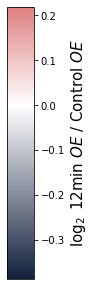

In [241]:
mappable = ax[0,1].collections[0]

fig, cax = plt.subplots(figsize=(2, 5))

cbar = fig.colorbar(mappable, cax=cax)

cax.set_aspect(17)

log2 = r'$\log_{2}$'
oe = r'${OE}$'

cbar.set_label(f'{log2} 12min {oe} / Control {oe}', fontsize=15)  # Update the label here

plt.show()
fig.savefig('colorbar.png', dpi=300, bbox_inches='tight')
fig.savefig('colorbar.svg', bbox_inches='tight')

In [242]:
# custom_cmap = cmp

# # Create a figure and axis
# fig, ax = plt.subplots(figsize=(6, 1))
# cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=custom_cmap), cax=ax, orientation='horizontal')

# tick_positions = [0,  1]
# #vmin, vmax = (norm.vmin), norm.vmax
# tick_labels = ["%.2f" % round(vmin, 2), "%.2f" % round(vmax, 2)]

# cbar.set_ticks(tick_positions)
# cbar.set_ticklabels(tick_labels, fontsize=15)

# oe = "${O/E}$"

# cbar.set_label(f'12min / Control {oe}', fontsize=16)

# fig.savefig('colorbar.png', dpi=300, bbox_inches='tight')
# fig.savefig('colorbar.svg', bbox_inches='tight')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Increase vs. Decrease: Mann-Whitney-Wilcoxon test two-sided, P_val:1.011e-01 U_stat=5.782e+05
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Increase vs. Decrease: Mann-Whitney-Wilcoxon test two-sided, P_val:5.911e-05 U_stat=5.269e+05


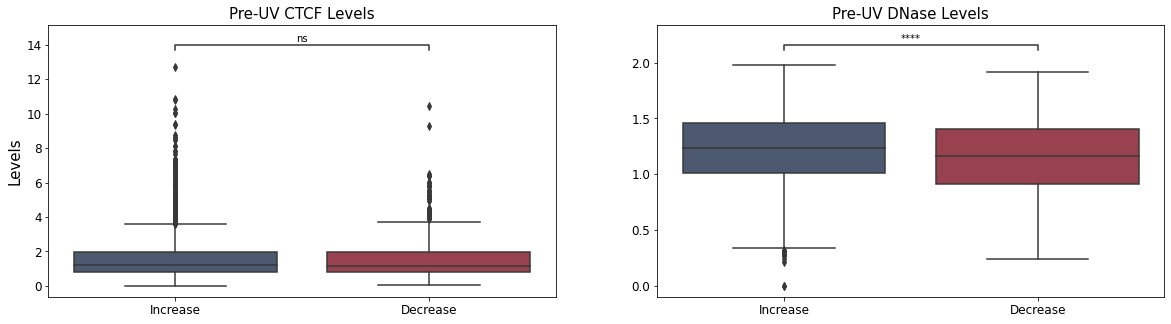

In [245]:
fig, axs = plt.subplots(1,2, figsize=(20, 5))

from statannotations.Annotator import Annotator

pairs = [('Increase', 'Decrease')]

title_mapping = {
    'ctcf': 'Pre-UV CTCF Levels',
    'dnase': 'Pre-UV DNase Levels',
    'faire': 'Pre-UV Faire Levels'
}
d_names = ['ctcf', 'dnase']#['ctcf', 'dnase', 'faire']
for i, data_name in enumerate(d_names):
    merged_dfs[data_name] = bbi.stackup(data_handlers.BWS[data_name], merged_dfs.chrom, merged_dfs.start, merged_dfs.end, bins=1)
    ax = axs[i]
    merged_dfs[data_name] = merged_dfs[data_name] / data_handlers.MEANS_BW[data_name]
    s = sns.boxplot(data=merged_dfs, x='dir', y=data_name, ax=ax, showfliers=True, palette=['#465775', '#A63446'])
    annotator = Annotator(ax, pairs, data=merged_dfs, x='dir', y=data_name)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
    annotator.apply_and_annotate()

    s.set_title(f'{title_mapping[data_name]}', fontsize=15)
    if i == 0:
        s.set_ylabel('Levels', fontsize=15)
    else:
        s.set_ylabel('')
    
    s.set_xlabel('')
    xticks = ['Increase', 'Decrease']
    s.set_xticks([0, 1])
    s.set_xticklabels(xticks, fontsize=15)
    s.tick_params(axis='both', which='major', labelsize=12)
    s.tick_params(axis='both', which='minor', labelsize=12)

fig.savefig('pre_uv_levels_boundary_centers.png', dpi=300, bbox_inches='tight')
fig.savefig('pre_uv_levels_boundary_centers.svg', bbox_inches='tight')

### CTCF ~ CBS ~ BS ~ REPAIR

In [45]:
merged_dfs = pd.concat(comps_dfs_).reset_index(drop=True)
merged_dfs = merged_dfs.loc[merged_dfs.type == 'Preserved']
merged_dfs = merged_dfs.loc[(merged_dfs.sample1 == 'Control') & (merged_dfs.sample2 == '12 min')]
boundary_idxs = merged_dfs.idx1.to_numpy().astype(int)
coords_table_preserved = insulation_table_[0].iloc[boundary_idxs][['chrom', 'start', 'end']].copy().reset_index(drop=True)
coords_table_preserved['bs1'] = merged_dfs.bs1.to_numpy()
coords_table_preserved['bs2'] = merged_dfs.bs2.to_numpy()
coords_table_preserved['bs_change'] = merged_dfs.bs2 - merged_dfs.bs1

In [ ]:
ctcf_peaks = pd.read_csv('/home/carlos/Downloads/ENCFF502CZS.bed', sep='\t', header=None)
ctcf_peaks = ctcf_peaks.iloc[:, :3].copy()
ctcf_peaks.columns = ['chrom', 'start', 'end']
coords_table_preserved['bs_row_idx'] = coords_table_preserved.index
overlap = bioframe.overlap(coords_table_preserved, ctcf_peaks)
overlap.dropna(subset=['chrom_'], inplace=True)
overlap

In [ ]:
coords_table_preserved['ctcf'] = region_per_df_wrapper(coords_table_preserved, bws_per_key['ctcf'], 1, interval_size=1000, flank=0).flatten()
coords_table_preserved['ctcf'] = np.log10(coords_table_preserved['ctcf'] + 1)

coords_table_preserved['cpd'] = region_per_df_wrapper(coords_table_preserved, bws_per_key['xr-cpd-over-sim'], 1, interval_size=1000, flank=0).flatten()
coords_table_preserved['64pp'] = region_per_df_wrapper(coords_table_preserved, bws_per_key['xr-64-over-sim'], 1, interval_size=1000, flank=0).flatten()

coords_table_preserved['dnase'] = region_per_df_wrapper(coords_table_preserved, bws_per_key['dnase'], 1, interval_size=1000, flank=0).flatten()

In [21]:
cbs_df = pd.read_csv('/home/carlos/oldies/manuscripts/review/tads/CTCF_all.tsv', sep='\t')
cbs_df.rename(columns={'seqnames': 'chrom'}, inplace=True)
cbs_df = cbs_df.loc[cbs_df.chrom.isin(clr_[0].chromnames)]
coords_table_preserved['row_idx'] = coords_table_preserved.index
cbs_boundary_ovarlap = bioframe.overlap(coords_table_preserved, cbs_df)
coords_table_preserved['n_cbs'] = cbs_boundary_ovarlap.groupby('row_idx').size().to_numpy().flatten()

windows = [(0,0), (1,1), (1,5), (5,10), (10, 1e6)]
window_labels = ['0', '1', '1-5', '5-10', '10+']
def assign_to_windows(arr, w):
    for i, (start, end) in enumerate(w):
        if start <= arr <= end:
            return i
    return -1

coords_table_preserved['window'] = coords_table_preserved['n_cbs'].apply(lambda x: assign_to_windows(x, windows))
coords_table_preserved = coords_table_preserved[coords_table_preserved['window'] > 0]

coords_table_preserved['window'] = coords_table_preserved['window'].apply(lambda x: window_labels[x])

coords_table_preserved['window'] = pd.Categorical(coords_table_preserved['window'], categories=window_labels[1:], ordered=True)

coords_table_preserved['cpd_dnase'] = coords_table_preserved['cpd'] / coords_table_preserved['dnase']
coords_table_preserved['cpd_levels'] = pd.qcut(coords_table_preserved['cpd'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

In [22]:
coords_table_preserved.loc[coords_table_preserved.bs_change < 0, 'direction'] = "decreased"
coords_table_preserved.loc[coords_table_preserved.bs_change >= 0, 'direction'] = "increased"

In [23]:
coords_table_preserved['bs_change_cbs'] = coords_table_preserved['bs_change'] / coords_table_preserved['n_cbs']

In [46]:
coords_table_preserved['ctcf_levels'] = pd.qcut(coords_table_preserved['ctcf'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

In [24]:
coords_table_preserved['cpd_dnase_levels'] = pd.qcut(coords_table_preserved['cpd_dnase'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
s = sns.violinplot(
    data=coords_table_preserved,
    x = 'window',
    y = 'bs_change',
    hue = 'ctcf_levels',
    #palette = ['red', 'blue', 'green', 'purple'],
    ax = ax
)
fig.savefig('/home/carlos/Downloads/ctcf_bs_change_cpd_levels.png', dpi=300, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
color_list = generate_colors(5)
for window in coords_table_preserved['window'].unique():
    sns.regplot(
        data=coords_table_preserved.loc[coords_table_preserved['window'] == window],
        x = 'ctcf',
        y = 'bs_change',
        scatter_kws={'s': 15, 'alpha': .5, 'color': "white"},
        line_kws={'lw': 3,'linestyle': '-', 'alpha': 1, 'color': color_list[window_labels.index(window)]},
        ax = ax,
        
    )

In [ ]:
s = sns.scatterplot(
    data=coords_table_preserved, 
    x='bs_change',
    y='n_cbs', 
    hue = "direction",)
s.axvline(0, color='black', linestyle='--', lw=2)

In [ ]:
import scipy
r, p = scipy.stats.pearsonr(x=coords_table_preserved['bs_change'], y=coords_table_preserved['ctcf'])

fig, ax = plt.subplots(figsize=(10, 5))

s = sns.scatterplot(data=coords_table_preserved, x='bs_change', y='ctcf', hue='window', palette='tab20', s=20, ax = ax)

plt.xlim(coords_table_preserved['bs_change'].min(), coords_table_preserved['bs_change'].max())
plt.ylim(coords_table_preserved['ctcf'].min(), coords_table_preserved['ctcf'].max())

#s.axhline(0, color='black', linestyle='--', lw=2)
s.tick_params(axis='both', which='major', labelsize=14)
s.set_xlabel('$Δ$ Boundary Strength', fontsize=18)
s.set_ylabel('CTCF Levels', fontsize=18)

# change legend title
new_title = '# CTCF Binding Sites'
s.legend_.set_title(new_title)

# save fig
plt.savefig('boundary_strength_ctcf.png', dpi=300, bbox_inches='tight')
plt.savefig('boundary_strength_ctcf.svg', bbox_inches='tight')



In [ ]:
import scipy

x='bs_change'
y='cpd'
hue='window'

plot_df = coords_table_preserved.dropna(subset=[x, y]).copy()

r, p = scipy.stats.pearsonr(x=plot_df[x], y=plot_df[y])

fig, ax = plt.subplots(figsize=(10, 5))

s = sns.scatterplot(data=plot_df, x=x, y=y, hue=hue, palette='tab20', s=20, ax = ax)


plt.xlim(plot_df[x].min(), plot_df[x].max())
plt.ylim(plot_df[y].min(), plot_df[y].max())

s.axhline(0, color='black', linestyle='--', lw=2)
s.tick_params(axis='both', which='major', labelsize=14)
s.set_xlabel(x, fontsize=18)
s.set_ylabel(f'{y} Levels', fontsize=18)

# change legend title
new_title = '# CTCF Binding Sites'
#s.legend_.set_title(new_title)